## NGDS-Projekt - Gruppe J

Namen und E-Mail-Adressen der Gruppenmitglieder:

- Melanie Rohrbacher, <rohrbme1@students.zhaw.ch> 
- (Adriana Grabar, <grabaadr@students.zhaw.ch> --> leider aus dem Studium ausgetreten, siehe Mail vom Mi, 23.04.24)

Zugeteilte Wetterstation:  SCU

### Bibliotheken importieren und globaler Parameter definieren

In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from scipy.integrate import simps

### 1. Daten importieren und bereinigen

Importiert die Daten (Strings und Zahlen getrennt), wählt die relevanten Spalten und Zeilen aus und löscht fehlende Werte. Am Ende sollt ihr je ein Array für den Messzeitpunkt (in Tagen seit der ersten Messung) und die gemessenen Wetterdaten für eure Wetterstation haben.

In [94]:
# Daten aus der CSV-Datei laden
data = pd.DataFrame(pd.read_csv("Graubuenden.csv", encoding='ascii'))

# Nur Daten für die Wetterstation "SCU" auswählen
scu_data = data[data['stn'] == 'SCU'].copy()  # Kopie des DataFrames erstellen

# Anzahl der Werte für die Wetterstation "SCU" anzeigen
num_values_scu = len(scu_data)
print("Anzahl der Werte für die Wetterstation 'SCU':", num_values_scu)

# Fehlende Werte löschen
scu_data.dropna(inplace=True)

# Das Datum in ein DateTime-Format konvertieren
scu_data['date_time'] = pd.to_datetime(scu_data['date_time'])

# Den ersten Messzeitpunkt als Referenzpunkt festlegen und die Zeit in Tagen seit diesem Zeitpunkt berechnen
start_date = scu_data['date_time'].min()
scu_data['time_days'] = (scu_data['date_time'] - start_date).dt.total_seconds() / (60 * 60 * 24)

# Relevanten Daten auswählen (stn, date_time, prestah0, tre200h0, rre150h0, su2000h0, time_days)
selected_columns = ['stn', 'date_time', 'prestah0', 'tre200h0', 'rre150h0', 'su2000h0', 'time_days']
scu_data = scu_data[selected_columns]

scu_data.reset_index(inplace=True)

# Ergebnis anzeigen
print("""
      
      Werte für die Wetterstation 'SCU':""")
scu_data

Anzahl der Werte für die Wetterstation 'SCU': 7453

      
      Werte für die Wetterstation 'SCU':


,index,stn,date_time,prestah0,tre200h0,rre150h0,su2000h0,time_days
0,74247,SCU,2023-01-01 00:00:00,880.7,0.3,0.0,0.0,0.000000
1,74248,SCU,2023-01-01 01:00:00,880.7,0.3,0.0,0.0,0.041667
2,74249,SCU,2023-01-01 03:00:00,880.7,0.0,0.0,0.0,0.125000
3,74250,SCU,2023-01-01 04:00:00,880.5,0.1,0.0,0.0,0.166667
4,74251,SCU,2023-01-01 08:00:00,881.1,0.1,0.0,0.0,0.333333
...,...,...,...,...,...,...,...,...
7448,81695,SCU,2023-12-31 19:00:00,861.3,-0.3,1.7,0.0,364.791667
7449,81696,SCU,2023-12-31 20:00:00,862.5,0.0,3.4,0.0,364.833333
7450,81697,SCU,2023-12-31 21:00:00,862.8,0.0,4.0,0.0,364.875000
7451,81698,SCU,2023-12-31 22:00:00,863.1,-0.4,1.6,0.0,364.916667


### 2. Interpolation

Wir haben 15% der Zeilen in den Originaldaten gelöscht. Also gibt es nicht genau stündlich Messwerte.

Bestimmt eine Interpolationsfunktion für jede Messgrösse und interpoliert die Messreihen viertelstündlich (d.h. für jede Stunde vier Werte plus den Endpunkt am 1. Januar um 0:00).

Wählt die Art und den Grad der Interpolation so aus, dass die interpolierten Werte auch physikalisch sinnvoll sind.

In [80]:
# Wähle das Zeitfenster von einer Woche aus
start_time = scu_data['time_days'].min()  # Startzeitpunkt
end_time = scu_data['time_days'].max()    # Endzeitpunkt

# Füge die Grenzen des Zeitfensters als zusätzliche Knotenpunkte hinzu
time_points = scu_data['time_days'].tolist()
time_points.extend([start_time, end_time])
time_points.sort()

# Wähle nur die relevanten Daten für die Interpolation aus
interpolation_prestah0 = scu_data[['time_days', 'prestah0']].copy()
interpolation_tre200h0 = scu_data[['time_days', 'tre200h0']].copy()
interpolation_rre150h0 = scu_data[['time_days', 'rre150h0']].copy()
interpolation_su2000h0 = scu_data[['time_days', 'su2000h0']].copy()

# Führe die Spline-Interpolation durch für prestah0
cs_prestah0 = CubicSpline(interpolation_prestah0['time_days'], interpolation_prestah0['prestah0'])

# Führe die Spline-Interpolation durch für tre200h0
cs_tre200h0 = CubicSpline(interpolation_tre200h0['time_days'], interpolation_tre200h0['tre200h0'])

# Führe die Spline-Interpolation durch für rre150h0
cs_rre150h0 = CubicSpline(interpolation_rre150h0['time_days'], interpolation_rre150h0['rre150h0'])

# Führe die Spline-Interpolation durch für su2000h0
cs_su2000h0 = CubicSpline(interpolation_su2000h0['time_days'], interpolation_su2000h0['su2000h0'])

# Bestimme die viertelstündlichen Zeitpunkte für die Interpolation
quarter_hour_time_points = np.linspace(start_time, end_time, num=97)

# Interpoliere die Werte für jeden viertelstündlichen Zeitpunkt für prestah0
interpolated_luftdruck = cs_prestah0(quarter_hour_time_points)

# Interpoliere die Werte für jeden viertelstündlichen Zeitpunkt für tre200h0
interpolated_temperatur = cs_tre200h0(quarter_hour_time_points)

# Interpoliere die Werte für jeden viertelstündlichen Zeitpunkt für rre150h0
interpolated_niederschlagsrate = cs_rre150h0(quarter_hour_time_points)

# Interpoliere die Werte für jeden viertelstündlichen Zeitpunkt für su2000h0
interpolated_sonnenscheindauer = cs_su2000h0(quarter_hour_time_points)

# Die Listen interpolated_prestah0, interpolated_tre200h0, interpolated_rre150h0 und interpolated_su2000h0 enthalten nun die viertelstündlich interpolierten Werte


### 3. Daten und Interpolation darstellen und vergleichen 

Um die Interpolation zu überprüfen, stellt für alle Variablen jeweils die Daten und die Interpolationsfunktion zusammen grafisch dar.

Wählt dazu ein Zeitfenster von ein paar Tagen, in dem alle Variablen ein etwas interessantes Verhalten zeigen, d.h. es fällt Regen und die Sonne scheint.

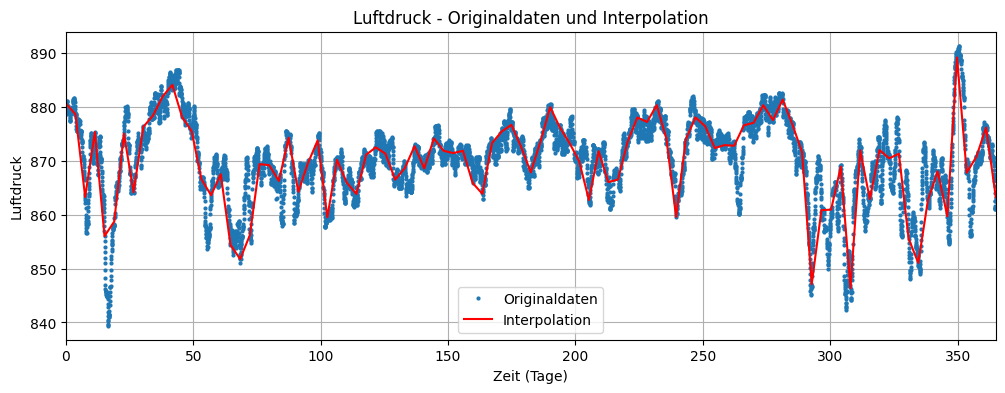

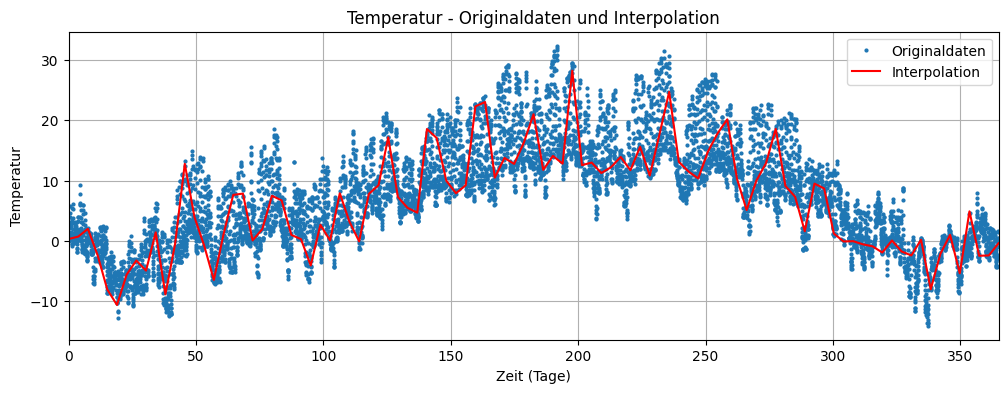

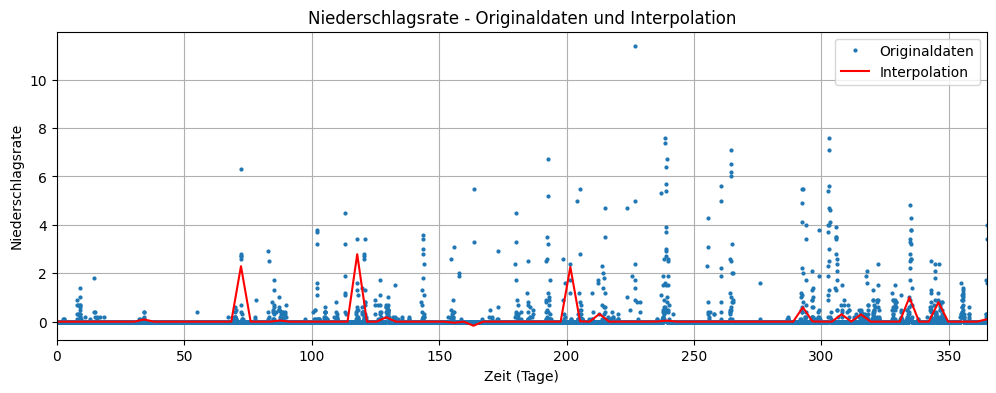

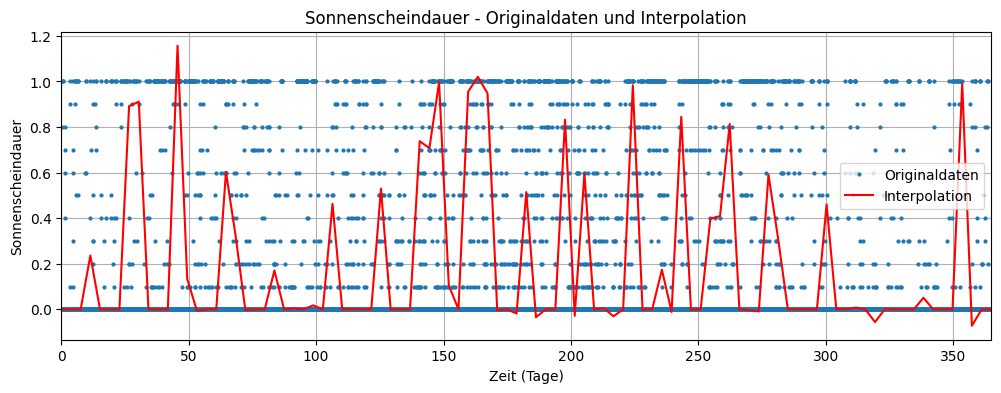

In [81]:
# Plot für Luftdruck
plt.figure(figsize=(12, 4))  # Ändere die Abmessungen des Diagramms
plt.plot(scu_data['time_days'], scu_data['prestah0'], 'o', markersize=2, label='Originaldaten')  # Ändere die Größe der Punkte
plt.plot(quarter_hour_time_points, interpolated_luftdruck, 'r-', label='Interpolation')
plt.xlabel('Zeit (Tage)')
plt.ylabel('Luftdruck')
plt.title('Luftdruck - Originaldaten und Interpolation')
plt.legend()
plt.grid(True)
plt.xlim(start_time, end_time)
plt.show()

# Plot für Temperatur
plt.figure(figsize=(12, 4))  # Ändere die Abmessungen des Diagramms
plt.plot(scu_data['time_days'], scu_data['tre200h0'], 'o', markersize=2, label='Originaldaten')  # Ändere die Größe der Punkte
plt.plot(quarter_hour_time_points, interpolated_temperatur, 'r-', label='Interpolation')
plt.xlabel('Zeit (Tage)')
plt.ylabel('Temperatur')
plt.title('Temperatur - Originaldaten und Interpolation')
plt.legend()
plt.grid(True)
plt.xlim(start_time, end_time)
plt.show()

# Plot für Niederschlagsrate
plt.figure(figsize=(12, 4))  # Ändere die Abmessungen des Diagramms
plt.plot(scu_data['time_days'], scu_data['rre150h0'], 'o', markersize=2, label='Originaldaten')  # Ändere die Größe der Punkte
plt.plot(quarter_hour_time_points, interpolated_niederschlagsrate, 'r-', label='Interpolation')
plt.xlabel('Zeit (Tage)')
plt.ylabel('Niederschlagsrate')
plt.title('Niederschlagsrate - Originaldaten und Interpolation')
plt.legend()
plt.grid(True)
plt.xlim(start_time, end_time)
plt.show()

# Plot für Sonnenscheindauer
plt.figure(figsize=(12, 4))  # Ändere die Abmessungen des Diagramms
plt.plot(scu_data['time_days'], scu_data['su2000h0'], 'o', markersize=2, label='Originaldaten')  # Ändere die Größe der Punkte
plt.plot(quarter_hour_time_points, interpolated_sonnenscheindauer, 'r-', label='Interpolation')
plt.xlabel('Zeit (Tage)')
plt.ylabel('Sonnenscheindauer')
plt.title('Sonnenscheindauer - Originaldaten und Interpolation')
plt.legend()
plt.grid(True)
plt.xlim(start_time, end_time)
plt.show()


### 4. Nullstellen der Temperatur bestimmen

Wählt einen von ca. einer Woche, in der die Temperatur um Null herum schwankt. 

Bestimmt die Zeitpunkte, an denen die Temperatur den Wert Null hat. Nutzt dazu die Interpolationsfunktion der Temperatur aus Schritt 2.

Stellt die Temperatur und die Nullstellen zusammen grafisch dar.

Alternativ (und ein wenig schwieriger) könnt ihr auch einen Zeitraum wählen, in der die Temperatur hohe Werte erreicht. Bestimmt dann die Zeitpunkte, an denen die Temperatur einen bestimmten Hitzewert überschreitet, z.B. 30 Grad.

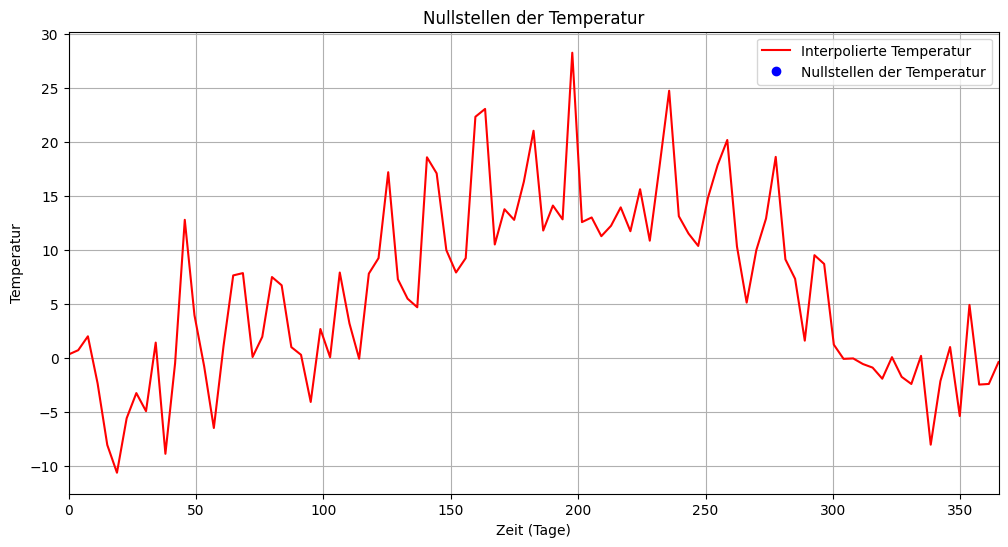

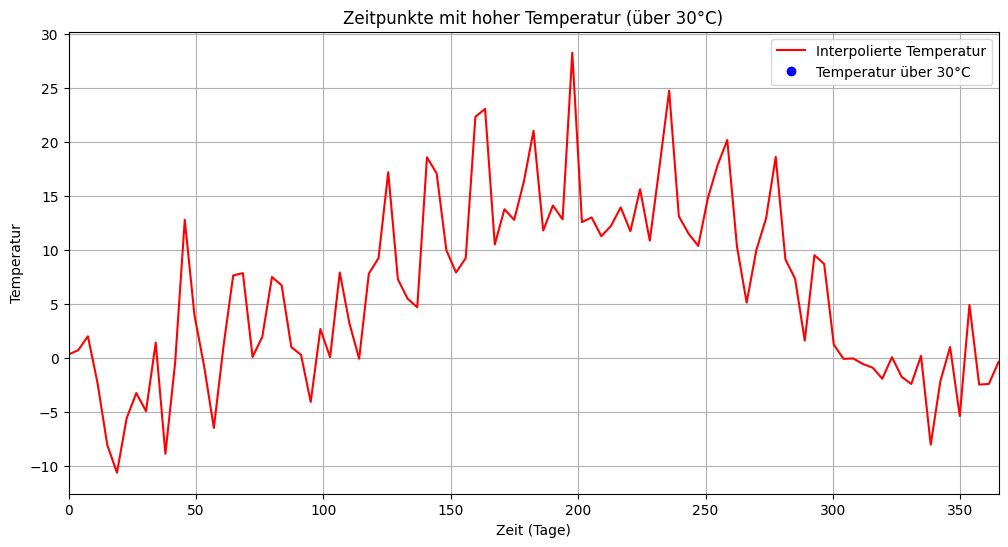

In [84]:
# Zeitpunkte, an denen die Temperatur Null erreicht
nullstellen_indices = np.where(np.isclose(interpolated_temperatur, 0, atol=0.01))[0]
nullstellen_time_points = quarter_hour_time_points[nullstellen_indices]

# Plot der Temperatur und der Nullstellen
plt.figure(figsize=(12, 6))
plt.plot(quarter_hour_time_points, interpolated_temperatur, 'r-', label='Interpolierte Temperatur')
plt.plot(nullstellen_time_points, np.zeros_like(nullstellen_time_points), 'bo', label='Nullstellen der Temperatur')
plt.xlabel('Zeit (Tage)')
plt.ylabel('Temperatur')
plt.title('Nullstellen der Temperatur')
plt.legend()
plt.grid(True)
plt.xlim(start_time, end_time)
plt.show()

hitze_indices = np.where(interpolated_temperatur > 30)[0]
hitze_time_points = quarter_hour_time_points[hitze_indices]

# Plot der Temperatur und der Zeitpunkte, an denen die Temperatur den Hitzewert überschreitet
plt.figure(figsize=(12, 6))
plt.plot(quarter_hour_time_points, interpolated_temperatur, 'r-', label='Interpolierte Temperatur')
plt.plot(hitze_time_points, interpolated_temperatur[hitze_indices], 'bo', label='Temperatur über 30°C')
plt.xlabel('Zeit (Tage)')
plt.ylabel('Temperatur')
plt.title('Zeitpunkte mit hoher Temperatur (über 30°C)')
plt.legend()
plt.grid(True)
plt.xlim(start_time, end_time)
plt.show()


### 5. Grosse Schwankungen in Temperatur oder Luftdruck finden

Betrachtet entweder die Temperatur oder den Luftdruck übers ganze Jahr. Berechnet die Ableitung der gewählten Variable und stellt diese auch dar, um einen Zeitraum von ca. 1 Woche mit grossen Schwankungen zu finden.

In der gewählten Woche mit grossen Schwankungen sollen nun die Zeitpunkte bestimmt werden, zu denen die Temperatur bzw. der Luftdruck am stärksten steigt bzw. fällt, also das Maximum und das Minimum der Ableitung.

Um das Maximum/Minimum eines Arrays zu finden, könnt ihr die Funktionen [`np.argmax`](https://numpy.org/doc/stable//reference/generated/numpy.argmax.htm) und [`np.argmin`](https://numpy.org/doc/stable//reference/generated/numpy.argmin.html) verwenden. 

In [86]:
# Annahme: Du hast bereits die Daten für Temperatur (interpolated_temperatur) oder Luftdruck (interpolated_luftdruck) und die viertelstündlichen Zeitpunkte (quarter_hour_time_points)

# Berechne die Ableitung der Temperatur oder des Luftdrucks
ableitung_temperatur = np.gradient(interpolated_temperatur, quarter_hour_time_points)
ableitung_luftdruck = np.gradient(interpolated_luftdruck, quarter_hour_time_points)

# Finde die Indizes der Zeitpunkte mit den größten Schwankungen (Maximum und Minimum der Ableitung)
max_steigung_temperatur_index = np.argmax(ableitung_temperatur)
min_steigung_temperatur_index = np.argmin(ableitung_temperatur)
max_steigung_luftdruck_index = np.argmax(ableitung_luftdruck)
min_steigung_luftdruck_index = np.argmin(ableitung_luftdruck)

# Bestimme die Zeitpunkte entsprechend der Indizes
zeitpunkt_max_steigung_temperatur = quarter_hour_time_points[max_steigung_temperatur_index]
zeitpunkt_min_steigung_temperatur = quarter_hour_time_points[min_steigung_temperatur_index]
zeitpunkt_max_steigung_luftdruck = quarter_hour_time_points[max_steigung_luftdruck_index]
zeitpunkt_min_steigung_luftdruck = quarter_hour_time_points[min_steigung_luftdruck_index]

# Drucke die Zeitpunkte mit den größten Schwankungen
print("Zeitpunkt mit der größten Steigung der Temperatur:", zeitpunkt_max_steigung_temperatur)
print("Zeitpunkt mit der größten Fallrate der Temperatur:", zeitpunkt_min_steigung_temperatur)
print("Zeitpunkt mit der größten Steigung des Luftdrucks:", zeitpunkt_max_steigung_luftdruck)
print("Zeitpunkt mit der größten Fallrate des Luftdrucks:", zeitpunkt_min_steigung_luftdruck)


Zeitpunkt mit der größten Steigung der Temperatur: 41.81814236111111
Zeitpunkt mit der größten Fallrate der Temperatur: 201.48741319444443
Zeitpunkt mit der größten Steigung des Luftdrucks: 345.95008680555554
Zeitpunkt mit der größten Fallrate des Luftdrucks: 288.92534722222223


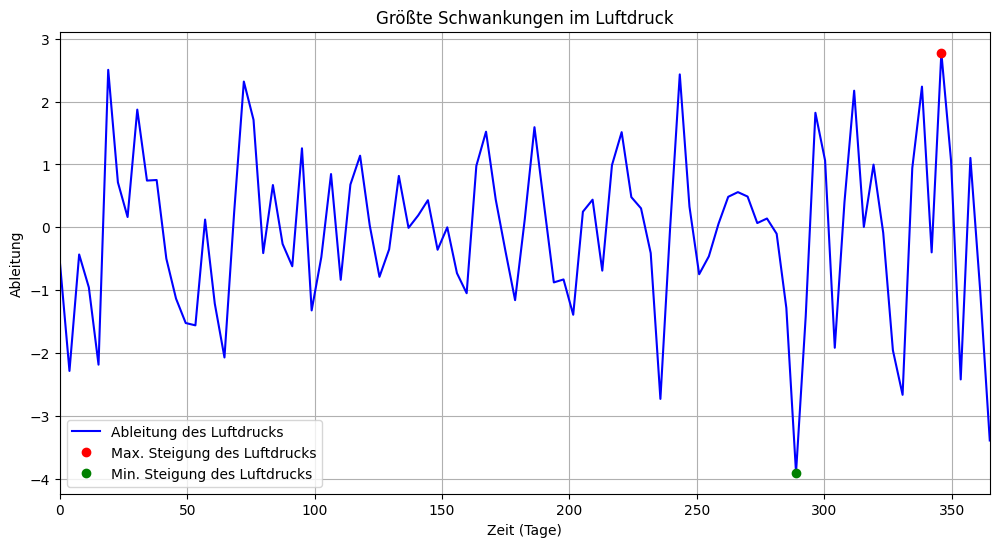

In [88]:
# Plot der Ableitung des Luftdrucks und der Zeitpunkte mit den größten Schwankungen
plt.figure(figsize=(12, 6))

# Plot der Ableitung des Luftdrucks
plt.plot(quarter_hour_time_points, ableitung_luftdruck, 'b-', label='Ableitung des Luftdrucks')

# Markierung der Zeitpunkte mit den größten Schwankungen im Luftdruck
plt.plot(zeitpunkt_max_steigung_luftdruck, ableitung_luftdruck[max_steigung_luftdruck_index], 'ro', label='Max. Steigung des Luftdrucks')
plt.plot(zeitpunkt_min_steigung_luftdruck, ableitung_luftdruck[min_steigung_luftdruck_index], 'go', label='Min. Steigung des Luftdrucks')

plt.xlabel('Zeit (Tage)')
plt.ylabel('Ableitung')
plt.title('Größte Schwankungen im Luftdruck')
plt.legend()
plt.grid(True)
plt.xlim(start_time, end_time)
plt.show()


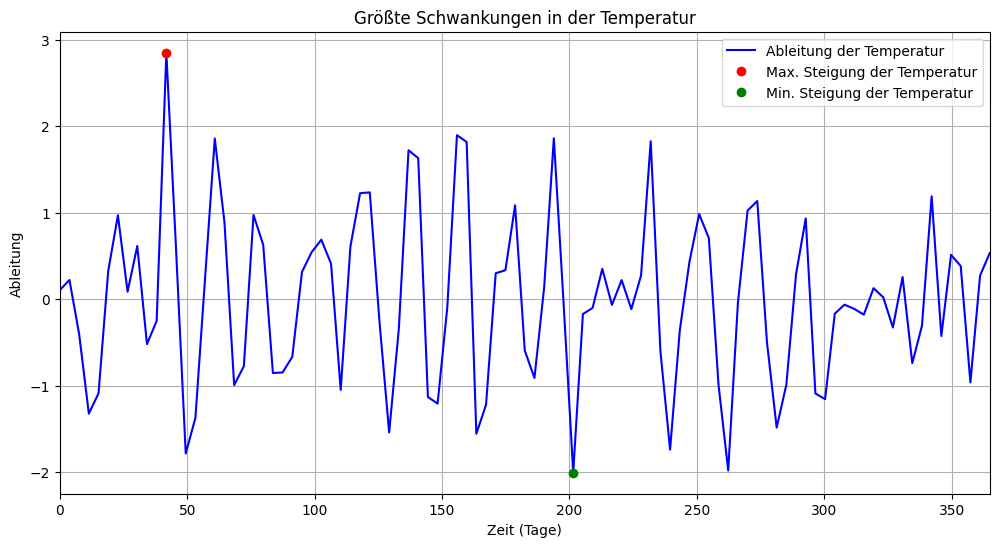

In [90]:
# Plot der Ableitung der Temperatur und der Zeitpunkte mit den größten Schwankungen
plt.figure(figsize=(12, 6))

# Plot der Ableitung der Temperatur
plt.plot(quarter_hour_time_points, ableitung_temperatur, 'b-', label='Ableitung der Temperatur')

# Markierung der Zeitpunkte mit den größten Schwankungen in der Temperatur
plt.plot(zeitpunkt_max_steigung_temperatur, ableitung_temperatur[max_steigung_temperatur_index], 'ro', label='Max. Steigung der Temperatur')
plt.plot(zeitpunkt_min_steigung_temperatur, ableitung_temperatur[min_steigung_temperatur_index], 'go', label='Min. Steigung der Temperatur')

plt.xlabel('Zeit (Tage)')
plt.ylabel('Ableitung')
plt.title('Größte Schwankungen in der Temperatur')
plt.legend()
plt.grid(True)
plt.xlim(start_time, end_time)
plt.show()


### 6. Mittelwerte berechnen

Wählt eine der Messgrössen aus und berechnet den Mittelwert über das ganze Jahr und den Mittelwert pro Monat. Der Einfachheit halber könnt ihr den Monat als 1/12 des Jahres definieren.

Stellt die eigentliche Variable und die Mittelwerte zusammen grafisch dar.

Die Mittelung soll mithilfe der Integration über die Interpolationsfunktion aus Schritt 2 berechnet werden.

Bei der Integration kann es Warnungen geben, da die Interpolationsfunktionen teils stark schwanken. Es kann hilfreich sein, mit dem Parameter `limit` die Anzahl Subintervalle zu erhöhen. Probiert aus, ab wann sich das Resultat nicht mehr gross ändert.

*Emphehlungen:* 
- Implementiert dies zuerst für die Temperatur, da diese am einfachsten zu interpretieren ist. Dann könnt ihr immer noch die anderen Messgrössen betrachten.
- Beginnt mit dem Mittelwert über das ganze Jahr, dann verallgemeinert für ein beliebiges Zeitintervall und iteriert schliesslich über die Monate.

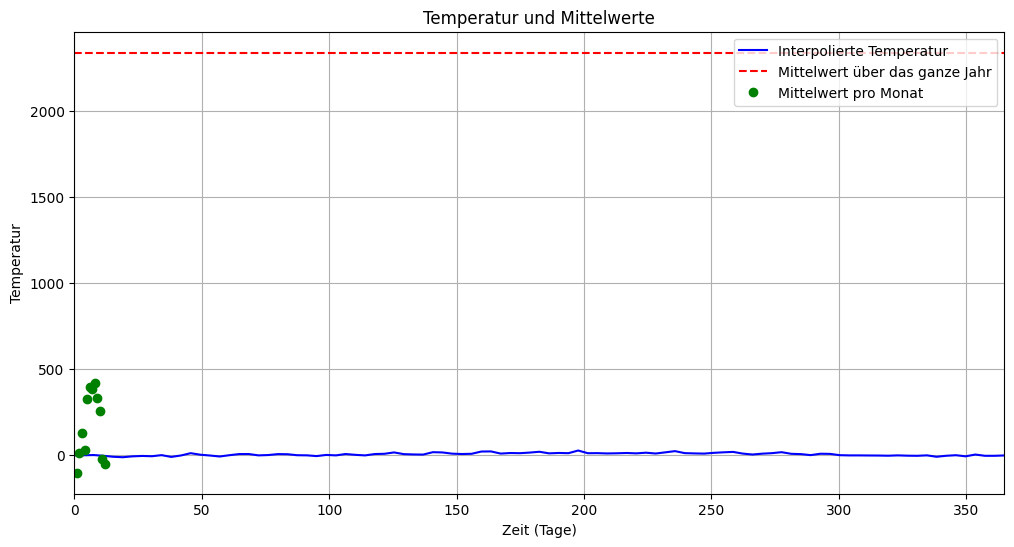

In [92]:
# Berechne den Mittelwert über das ganze Jahr
mittelwert_ganzes_jahr_temperatur = simps(interpolated_temperatur, quarter_hour_time_points)

# Berechne den Mittelwert pro Monat
tage_pro_monat = len(quarter_hour_time_points) / 12  # Anzahl der Tage pro Monat
mittelwerte_pro_monat_temperatur = []
for i in range(12):
    start_index = int(i * tage_pro_monat)
    end_index = int((i + 1) * tage_pro_monat)
    mittelwert_pro_monat_temperatur = simps(interpolated_temperatur[start_index:end_index], quarter_hour_time_points[start_index:end_index])
    mittelwerte_pro_monat_temperatur.append(mittelwert_pro_monat_temperatur)

# Plot der Temperatur und der Mittelwerte
plt.figure(figsize=(12, 6))
plt.plot(quarter_hour_time_points, interpolated_temperatur, 'b-', label='Interpolierte Temperatur')
plt.hlines(mittelwert_ganzes_jahr_temperatur, quarter_hour_time_points[0], quarter_hour_time_points[-1], colors='r', linestyles='dashed', label='Mittelwert über das ganze Jahr')
plt.plot(np.arange(1, 13), mittelwerte_pro_monat_temperatur, 'go', label='Mittelwert pro Monat')
plt.xlabel('Zeit (Tage)')
plt.ylabel('Temperatur')
plt.title('Temperatur und Mittelwerte')
plt.legend()
plt.grid(True)
plt.xlim(start_time, end_time)
plt.show()


### 7. Glättung (Gleitendes Mittel) bestimmen

Nehmt die gleiche Messgrösse wie in Schritt 6 und berechnet das gleitende Mittel über das ganze Jahr. Dazu soll die Faltung mit einer symmetrischen Rechteckfunktion verwendet werden. Die Fensterbreite (Breite des Rechtecks) soll ein Parameter sein, den ihr variieren könnt.

Stellt die Messgrösse und das gleitende Mittel mit Fensterbreite = 1 Woche zusammen dar. Optional könnt ihr dazu auch noch das gleitende Mittel mit Fensterbreite = 1 Monat darstellen.

*Vorsicht:* Die Faltung ist rechenintensiv. Berechnet also zuerst das gleitende Mittel an wenigen Zeitpunkten über das ganze Jahr, z.B. 100, und erhöht dann die Anzahl Zeitpunkte vorsichtig.

### Zusammenfassung

### Reflexion

Mitglied 1: Melanie Rohrbacher
- Was hat gut funktioniert?
    - Aufgabenverteilung und Kommunikation zueinander (für die ersten paar Wochen)

- Was hat nicht gut funktioniert?
    - Der Kampf, die Grafik so darzustellen, wie ich es im Kopf haben wollte

- Was würdest du beim nächsten Mal anders machen?
    - Mehr Zeit für die Aufgaben einplanen 

- Was hast du gelernt?
    - Dass Python ein mächtiges Tool ist, welches ich noch nicht vollständig beherrsche
    - Generell alle Themen des Moduls sind mir neu (ausserhalb des Unterrichts noch nie was von Interpolation gehört)
    - Verküpfte Arbeitsweise zwischen dem Aufgabenmaterial im Unterricht und besseres prompting ChatGPT
    - ChatGPT und andere KI-Tools werden zukünftig diese Arbeit vollständig übernehmen, doch bis jetzt ist es noch nicht so ausgereift und fehlerhaft


- Was war die grösste Herausforderung?
    - Auch wenn es eigentlich eine Teamarbeits sein sollte, die Sache irgendwie allein durchzuboxen 
    
- usw.
